In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local[1]').setAppName('my app')
sc = SparkContext.getOrCreate(conf=conf)

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-income').getOrCreate()

## (a)

### preprocess training and test data

In [17]:
from pyspark.sql.types import *
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", DoubleType(), True),
    StructField("education", StringType(), True),
    StructField("education-num", DoubleType(), True),
    StructField("maritial-status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital-gain", DoubleType(), True),
    StructField("capital-loss", DoubleType(), True),
    StructField("hours-per-week", DoubleType(), True),
    StructField("native-country", StringType(), True),
    StructField("income", StringType(), True),
])
train = spark.read.csv('adult.data', header = True, schema = schema)
test = spark.read.csv('adult.test', header = True, schema = schema)

In [18]:
from pyspark.sql.functions import *
import pandas as pd
period_remove = udf(lambda x: x.replace(".",""),StringType())
test =test.withColumn("income", period_remove("income"))

In [19]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['workclass', 'education', 'maritial-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [20]:
train = train.select("age","workclass", "fnlwgt", "education", "education-num", "maritial-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income")
cols = train.columns

In [21]:
test = test.select("age","workclass", "fnlwgt", "education", "education-num", "maritial-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income")
cols2 = test.columns

In [22]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train)
train = pipelineModel.transform(train)
selectedCols = ['label', 'features'] + cols
train = train.select(selectedCols)

In [23]:
test = pipelineModel.transform(test)
selectedCols = ['label', 'features'] + cols2
test = test.select(selectedCols)

## a. building model on training data

### RandomForestClassifier

In [66]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [67]:
prediction = rfModel.transform(test)

## a. tuning hyperparameters

In [31]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [1, 3, 10, 20]) \
    .addGrid(rf.subsamplingRate, [0.2, 0.4, 0.6, 0.8, 1]) \
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt"]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

pipeline2 = Pipeline(stages = [crossval])
cvModel = pipeline2.fit(train)

In [37]:
cvModel.stages[-1].bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_ae90b3961536', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='RandomForestClassifier_ae90b3961536', name='labelCol', doc='label column name.'): 'label',
 Param(parent='RandomForestClassifier_ae90b3961536', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='RandomForestClassifier_ae90b3961536', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='RandomForestClassifier_ae90b3961536', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='RandomForestClassifier_ae90b3961536', name='seed', doc='random seed.'): -1810310145176042102,
 Param(parent='RandomForestClassifier_ae90b3961536', name='cacheNodeIds', doc='If false, the

## a. best hyperparameters

In [38]:
cvModel.stages[-1].bestModel.getNumTrees

20

In [46]:
cvModel.stages[-1].bestModel.getOrDefault("subsamplingRate")

0.2

In [44]:
cvModel.stages[-1].bestModel.getOrDefault("featureSubsetStrategy")

'auto'

#### the best hyperparameters are shown above as a result 

## (b)

## b. feature importances

In [47]:
rfModel.featureImportances

SparseVector(100, {0: 0.0001, 1: 0.0005, 2: 0.0005, 3: 0.0011, 4: 0.0002, 5: 0.0143, 6: 0.0003, 8: 0.0178, 10: 0.0117, 11: 0.0097, 13: 0.0031, 14: 0.0003, 16: 0.0029, 17: 0.0065, 18: 0.0001, 20: 0.0031, 22: 0.0001, 23: 0.2443, 24: 0.0846, 25: 0.004, 26: 0.0004, 27: 0.0006, 29: 0.0221, 30: 0.0, 31: 0.0134, 32: 0.0011, 33: 0.0, 34: 0.0046, 35: 0.0008, 37: 0.0, 38: 0.0002, 39: 0.0004, 40: 0.0002, 42: 0.0004, 43: 0.0683, 44: 0.0218, 45: 0.0323, 46: 0.0054, 47: 0.0302, 49: 0.0018, 52: 0.0187, 53: 0.0001, 54: 0.0012, 55: 0.0, 57: 0.0001, 63: 0.0, 65: 0.0001, 66: 0.0, 67: 0.0001, 68: 0.0, 69: 0.0001, 71: 0.0, 73: 0.0, 74: 0.0001, 77: 0.0001, 83: 0.0, 87: 0.0001, 89: 0.0, 92: 0.0001, 94: 0.0215, 95: 0.0002, 96: 0.1335, 97: 0.1188, 98: 0.0522, 99: 0.0441})

In [48]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [49]:
ExtractFeatureImp(rfModel.featureImportances, train, "features")

,idx,name,score
29,23,maritial-statusclassVec_ Married-civ-spouse,0.244257
2,96,education-num,0.133518
3,97,capital-gain,0.118784
30,24,maritial-statusclassVec_ Never-married,0.084600
49,43,relationshipclassVec_ Husband,0.068321
...,...,...,...
66,60,native-countryclassVec_ El-Salvador,0.000000
67,61,native-countryclassVec_ India,0.000000
68,62,native-countryclassVec_ Cuba,0.000000
70,64,native-countryclassVec_ Jamaica,0.000000


#### The most important feature is the maritial status of someone with a married spouse. The fact that this feature has the highest score make sense because someone with a married spouse will most likely a family to support if not just supporting the spouse. The individual would most likely has a stronger initiative to search for a higher income job to support the family
#### Followed up we can see education-num, which is most likely the highest level of education achieved. This also make sense as we are living in a modern world where knowledge and education contribute a large portion to one's income.
#### In the third place on the list we can see "capital-gain". If one has a high capital-gain, the individual is most likely to be wealthy in the sense that he has the capital to invest in stocks, bonds and other kinds of investment. It will also means that the individual will have a high income.

## (c)

## RandomForestClassifier vs GBTClassifier

### RandomForestClassifier predictions

In [68]:
type(prediction)

pyspark.sql.dataframe.DataFrame

In [69]:
prdt = prediction.select(['label','probability', 'prediction']).toPandas()

//home/tutorial/spark-3.0.0-preview2-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2184: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [70]:
prdt.head(5)

,label,probability,prediction
0,0.0,"[0.6930885679062655, 0.3069114320937345]",0.0
1,1.0,"[0.7030236228093611, 0.29697637719063874]",0.0
2,1.0,"[0.5402641395853108, 0.45973586041468906]",0.0
3,0.0,"[0.937506759066204, 0.06249324093379603]",0.0
4,0.0,"[0.905331241226499, 0.09466875877350099]",0.0


In [71]:
label = list(prdt['label'])
prediction = list(prdt['prediction'])
probability = [x[1] for x in prdt['probability']]

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
fpr, tpr, _ = roc_curve(label, probability)
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(label, prediction)
precision = precision_score(label, prediction)
recall = recall_score(label, prediction)
f1 = f1_score(label, prediction)

In [73]:
print('auc: ', roc_auc)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1: ', f1)

auc:  0.8919497547152971
accuracy:  0.8287469287469288
precision:  0.8198307134220073
recall:  0.35257410296411856
f1:  0.4930909090909091


## c.ii. plotting roc for RandomForestClassifier

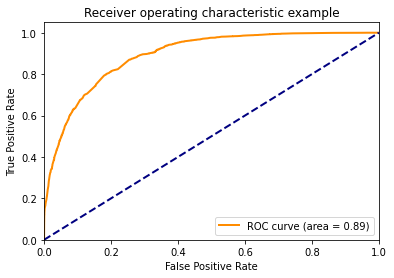

In [74]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### GBTClassifier

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

In [97]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

gbt = GBTClassifier(featuresCol="features", labelCol = 'label')
gbtModel = gbt.fit(train)
predictions2 = gbtModel.transform(test)

In [98]:
pr = predictions2.select(['label','probability', 'prediction']).toPandas()

//home/tutorial/spark-3.0.0-preview2-bin-hadoop2.7/python/pyspark/sql/dataframe.py:2184: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warnings.warn(msg)


In [99]:
label = list(pr['label'])
prediction = list(pr['prediction'])
probability = [x[1] for x in pr['probability']]

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

fpr, tpr, _ = roc_curve(label, probability)
roc_auc = auc(fpr, tpr)
accuracy = accuracy_score(label, prediction)
precision = precision_score(label, prediction)
recall = recall_score(label, prediction)
f1 = f1_score(label, prediction)

In [101]:
print('auc: ', roc_auc)
print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('f1: ', f1)

auc:  0.9097265072845153
accuracy:  0.8571253071253071
precision:  0.7662929222144359
recall:  0.5686427457098284
f1:  0.6528358208955225


## c.ii. plotting roc for GBTClassifier

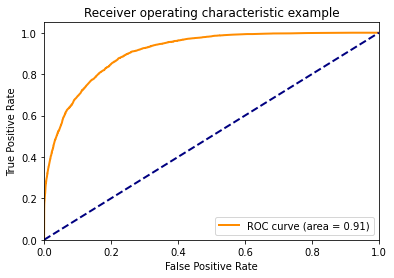

In [102]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## c. i. comparing RandomForestClassifier and GBTClassifier

#### RandomForestClassifier
auc:  0.8919497547152971<br>
accuracy:  0.8287469287469288<br>
f1:  0.4930909090909091<br>

#### GBTClassifier
auc:  0.9097265072845153<br>
accuracy:  0.8571253071253071<br>
f1:  0.6528358208955225

#### Gbt has a higher accuracy than RandomForest
#### Gbt is better at distinguishing between classes as it has higher auc
#### f1 score is higher in Gbt, meaning it has higher precision and recall is higher